The goal of this exercise is to go through the Machine Learning modeling process using Python.

I'll recover the dataset I used in [this]() and [this]() blog posts about energy savings in building renovation strategies. Check them for further context.

The Machine Learning end-2-end project consists of the following steps:

+ Selecting the performance measure
+ Checking the modeling assumptions
+ Quick exploration of data
+ Creating the test set
+ Exploring the data visually to gain insights
+ Attribute combination A.K.A. Feature Engineering
+ Preparing the data for ML models
+ Model selection and training, and finally
+ Model testing

I'll drive you through each of the steps, going into enough detail to give you a general idea of how each works.

## Performance measure

The performance measure is an indicator that gives an idea of how much error the system makes in its predictions. You'll get an idea of what I'm talking about with this image.

![](img/error.png)

The performance measure selected for this project is Root Mean Squared Error (RMSE), as it is a standard error measure when it comes to Regression tasks[[3]](#references). It is described as follows:

$$RMSE(X,h)=\sqrt{\frac{1}{m}\sum^m_{i=1}(h(x^{(i)}) - y^{(i)})^2}$$

Where,

* $X$ is the matrix containing all the features, excluding the label or target variable
* $h$ is the hypothesis, i.e., the model function
* $m$ is the length of the dataset, i.e., the number of instances or buildings in it
* $x^{(i)}$ is a vector of all the feature values (excluding the label) of the $i^{th}$ instance in the dataset. Hence, $h(x^{(i)})$ gives us the "predicted $y$"
* $y$ is the real target value

This performance measure imputes higher weight for large errors.

## Asumptions

We have in our hands a regression task. We will use the data set to predict the building's energy consumption.

The data I use for this post has some limitations. Mainly:
* the target variable is a calculated attribute, 
* there will be errors and outliers derived from the data collection process

I assume that anyone that reaches this notebook will have some basic familiarity with Python and Machine Learning. Anyhow, I'll try to do it as accessible as possible to someone with little to no knowledge.

![](img/ml-explained.jpeg)

Sometimes, variables are referred to as "attributes" or "features" while "attributes" is the preferred one.

## Configuration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import shapefile as shp
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format ='retina'

mpl.rcParams['figure.figsize'] = (10, 6)
sns.set(style = 'whitegrid', font_scale = 1)

## Get the data

In [2]:
buildings = pd.read_csv("../santboi/data/1906SB_collection_heatd.csv")

## Quick Data Exploration

In [3]:
print('ORIGINAL DATA:')
buildings.info(null_counts=True)

ORIGINAL DATA:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X Coord                    746 non-null    float64
 1   Y Coord                    746 non-null    float64
 2   District                   814 non-null    object 
 3   Year                       814 non-null    int64  
 4   Main Orientation           814 non-null    object 
 5   GF Usage                   814 non-null    object 
 6   Roof Surface               814 non-null    float64
 7   Facade Surface             814 non-null    float64
 8   Openings Surface           814 non-null    float64
 9   Wrapping Surface           814 non-null    float64
 10  Party Wall Surface         814 non-null    float64
 11  Contact w/Terrain Surface  814 non-null    float64
 12  Type of Roof               814 non-null    object 
 13  Type of Opening            814 non-

Print the data to see how it looks like

In [4]:
buildings.head()

,X Coord,Y Coord,District,Year,Main Orientation,GF Usage,Roof Surface,Facade Surface,Openings Surface,Wrapping Surface,Party Wall Surface,Contact w/Terrain Surface,Type of Roof,Type of Opening,Type of Party Wall,Type of Facade,Number of Floors,Number of Courtyards,Number of Dwellings,Heat Demand
0,2.032087,41.348370,Marianao,1977,E,Commercial,165.43,208.50,56.1150,1473.28,150.9,150.00,C2,H4,M2,F3,5,1,5,44.251546
1,2.032074,41.348412,Marianao,1978,W,Commercial,417.41,547.35,218.9400,2524.31,36.6,420.00,C2,H3,M2,F3,5,2,19,38.328312
2,2.032024,41.348669,Marianao,1976,E,Commercial,202.00,282.00,112.8000,1637.97,108.9,202.07,C2,H3,M2,F3,5,2,14,58.794629
3,2.043332,41.338324,Vinyets,1959,NW,Dwelling,96.00,148.80,38.4024,489.60,0.0,96.00,C1,H3,0,F1,3,0,2,126.321738
4,2.043382,41.338281,Vinyets,1958,NE,Dwelling,45.00,61.38,18.4170,418.31,0.0,80.00,C1,H4,0,F1,2,1,2,69.562085


I got latitude and longitude via the [Spanish Cadastre API](https://ovc.catastro.meh.es/ovcservweb/ovcswlocalizacionrc/ovccoordenadas.asmx). There are 68 nulls in those variables because some references have errors.

Let's see how is our categorical data.

In [5]:
buildings["District"].value_counts()

Marianao    499
Vinyets     315
Name: District, dtype: int64

This is an important variable, as we the approach of the study is highly dependent on the terreitory.

In [6]:
buildings["Main Orientation"].value_counts()

N     134
S     131
E     109
W     106
SE     98
NE     86
NW     79
SW     71
Name: Main Orientation, dtype: int64

In [7]:
buildings["GF Usage"].value_counts()

Dwelling      401
Commercial    355
Storage        41
Industrial     17
Name: GF Usage, dtype: int64

The same occurs with the following, where categories are a direct representation of the physical characteristics of the corresponding wrapping surface.

Let's see some statistics.

In [8]:
buildings.describe()

,X Coord,Y Coord,Year,Roof Surface,Facade Surface,Openings Surface,Wrapping Surface,Party Wall Surface,Contact w/Terrain Surface,Number of Floors,Number of Courtyards,Number of Dwellings,Heat Demand
count,746.000000,746.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000
mean,2.037112,41.344455,1958.713759,188.012064,283.197881,92.051687,1174.339019,89.446564,191.163845,3.819410,1.067568,8.509828,78.686759
std,0.005807,0.004975,24.095145,162.277031,346.681371,154.381926,991.088501,144.038287,166.748749,1.811693,1.209477,10.797443,41.569118
min,2.028457,41.334829,1700.000000,30.080000,14.280000,2.570000,150.920000,0.000000,38.610000,1.000000,0.000000,1.000000,5.977362
25%,2.032491,41.339325,1958.000000,91.000000,77.334300,18.899490,494.850000,0.000000,93.812500,2.000000,0.000000,1.000000,48.330863
50%,2.034446,41.346671,1967.000000,129.565000,157.920000,40.266405,851.655000,33.985500,131.500000,4.000000,1.000000,4.000000,69.391495
75%,2.043433,41.349227,1973.000000,224.587500,344.475000,94.001554,1497.847500,117.810000,225.532500,5.000000,2.000000,12.000000,99.243290
max,2.046343,41.352760,1979.000000,1367.000000,2765.940000,1795.254000,6159.730000,1287.270000,1405.000000,8.000000,7.000000,83.000000,233.075410


The only thing that catches my attention is that there is a high maximum for Heat Demand.

Let's complement them with plots.

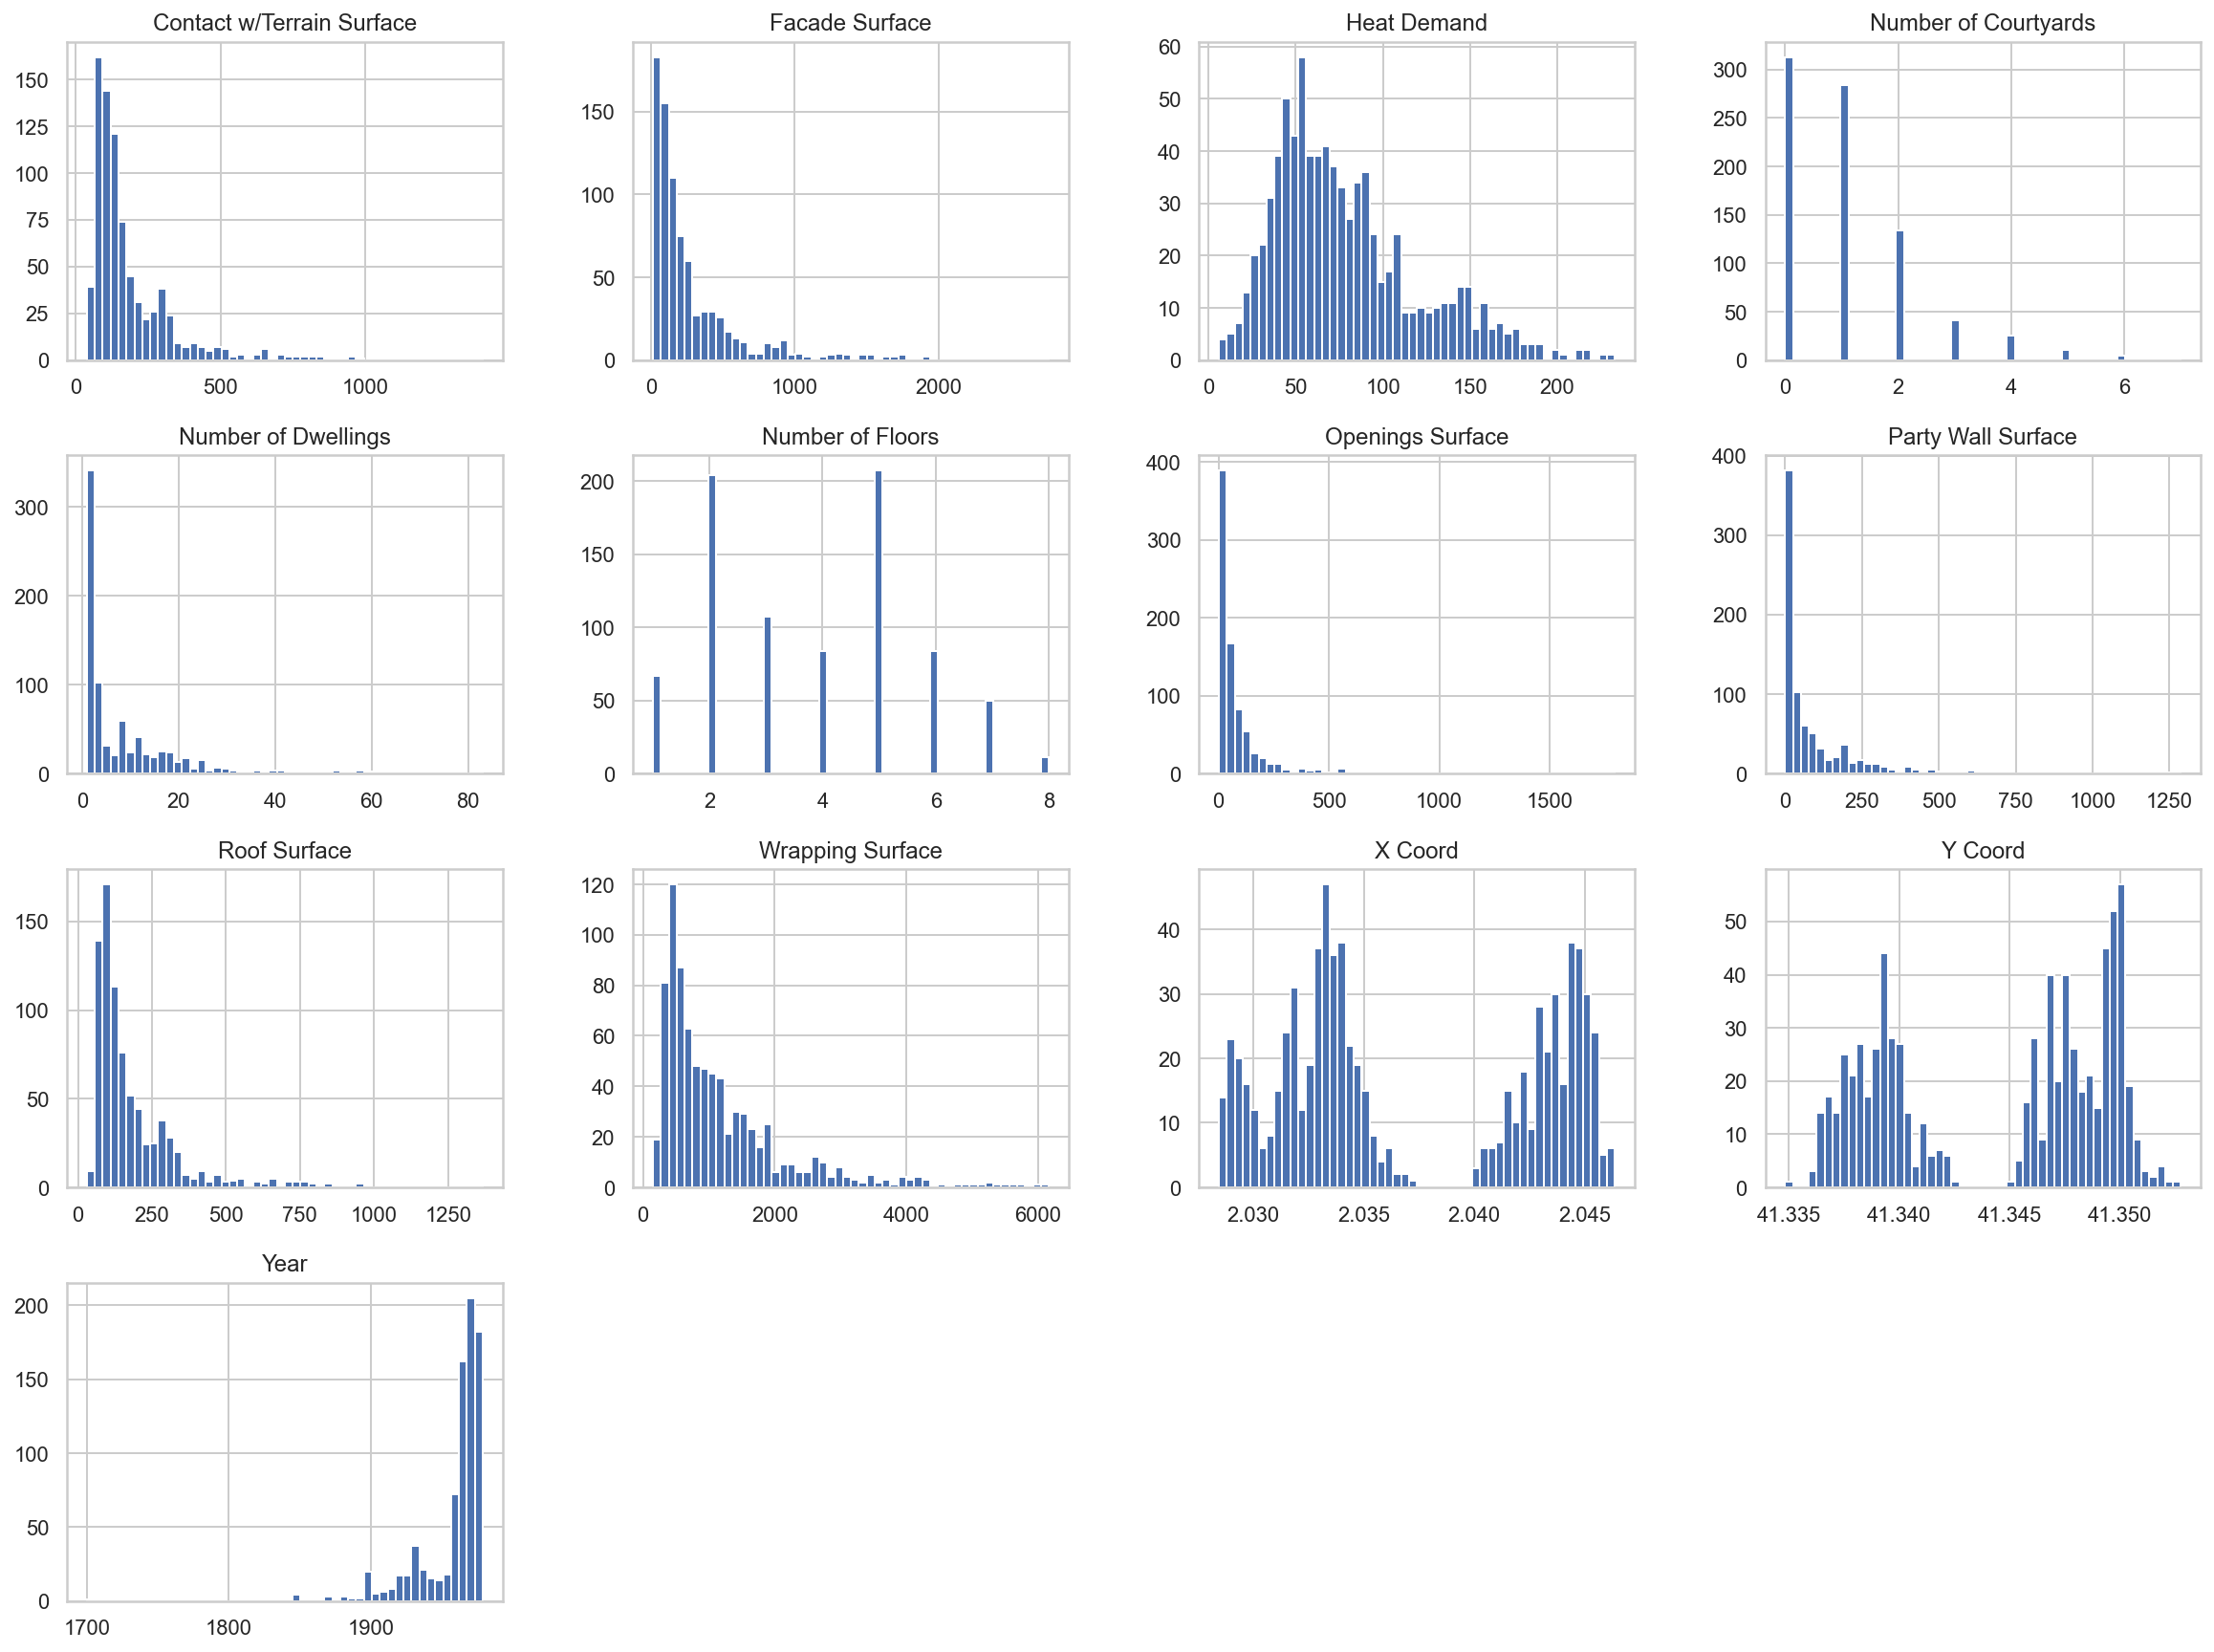

In [9]:
buildings.hist(bins=50, figsize=(20,15))
plt.show()

Now we can observe some peculiarities in data:

* Two numerical attributes, `Number of Courtyards` and `Number of floors`, shall be considered as categorical or numeric
* Most buildings have 2 or 5 heights
* Many distributions are _tail-heavy_
* The Attributes have different scales
* Heat demand shows a bimodal distribution (i.e., two peaks). It indicates that an important category is producing this difference.

# Create the Test Set

After getting a quick look at the data, the next thing we need to do is putting aside the test set (i.e., the dataset we will use to test our model's performance with data that it does not know) to ignore it until the appropriate moment.

The approach of this study is territory-wise. It must be taken into account when splitting the dataset in the train and test set. Data in both sets must be representative of each District.

Another fundamental attribute is `Number of Floors`. Hence, data is stratified concerning this variable too.

Here, the proportions in the whole dataset for both variables.

In [10]:
print("DISTRICT PROPORTIONS:")
buildings["District"].value_counts(normalize=True)

DISTRICT PROPORTIONS:


Marianao    0.613022
Vinyets     0.386978
Name: District, dtype: float64

In [11]:
print("NUMBER OF FLOORS PROPORTIONS:")
buildings["Number of Floors"].value_counts(normalize=True)

NUMBER OF FLOORS PROPORTIONS:


5    0.254300
2    0.250614
3    0.131450
6    0.103194
4    0.103194
1    0.082310
7    0.061425
8    0.013514
Name: Number of Floors, dtype: float64

Now we are prepared to implement **Scikit-Learn's** `StratifiedShuffleSplit` class. You will see that Scikit-Learn classes are used in several moments. This is the best practice when it comes to automate and make reproducible all the steps in a Machine Learning Project conducted with python.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(buildings, buildings.loc[:,("District", "Number of Floors")]):
    buildings_train_set = buildings.loc[train_index]
    buildings_test_set = buildings.loc[test_index]

In [13]:
print("DISTRICT PROPORTIONS IN TEST SET:")
buildings_test_set["District"].value_counts(normalize=True)

DISTRICT PROPORTIONS IN TEST SET:


Marianao    0.613497
Vinyets     0.386503
Name: District, dtype: float64

In [14]:
print("NUMBER OF FLOORS PROPORTIONS IN TEST SET:")
buildings_test_set["Number of Floors"].value_counts(normalize=True)

NUMBER OF FLOORS PROPORTIONS IN TEST SET:


5    0.257669
2    0.251534
3    0.128834
6    0.104294
4    0.104294
1    0.085890
7    0.055215
8    0.012270
Name: Number of Floors, dtype: float64

# Exploring Data Visually to Gain Insights

Univariate analysis was already performed. [Clic here to see more](https://github.com/carlosdavila91/santboi_eda).

This exploration is performed over the training data to avoid early catching patterns in the test data.

In [15]:
buildings = buildings_train_set.copy()

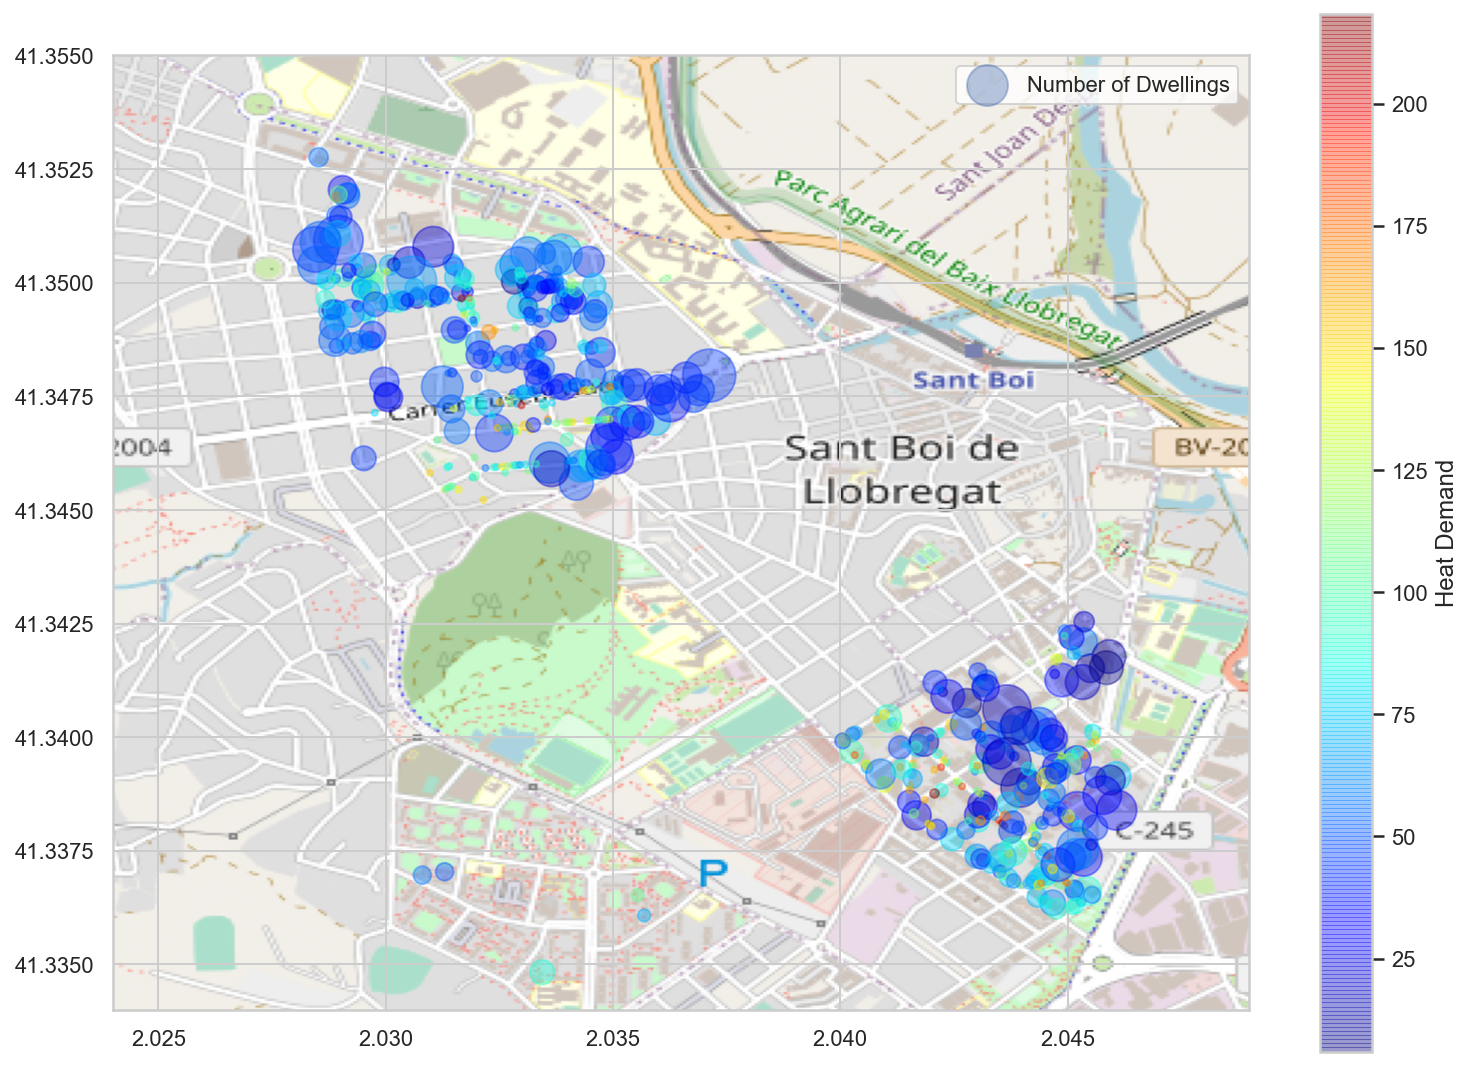

In [16]:
import matplotlib.patches as patches

x = buildings["X Coord"]
y = buildings["Y Coord"]
s = buildings["Number of Dwellings"]
hd = buildings["Heat Demand"]
label = buildings["Number of Dwellings"]
cmap=plt.get_cmap('jet')

sb_map = plt.imread("img/map.png")
bbox = (2.024, 2.049, 41.334, 41.355)

fig = plt.figure(figsize=(4*7,3*7))
ax = plt.subplot(221)
scat = plt.scatter(x=x, y=y, label=label, alpha=0.4, s=s*10, c=hd, cmap=cmap)
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
plt.imshow(sb_map, zorder=0, extent = bbox, aspect='equal')
plt.colorbar(scat, label="Heat Demand")
ax.legend(["Number of Dwellings"])

plt.show()

Credits to [openstreemap.org](https://www.openstreetmap.org/) for the image in the background.

Some things we can notice examining the map are:

* The small buildings, represented with small circles, tend to be red or clear blue. It means that their estimated Heat Demand is higher.
* The size of the building is undoubtedly a determining attribute when it comes to heat demand.

## Correlations

To measure the correlation between variables, we can calculate the Pearson's correlation coefficient. This will give us an idea of the linear correlations between variables. In our case, we want to see how all variables correlate with our target variable, which is `Heat Demand`.

To interpret it, we should know that:

* Strong correlations exist as the Pearson's correlation coefficient comes close to `1` or `-1`.
* When it is positive, it means that there is a positive correlation, or that both compared variables increase in the same direction. When it is negative, as one of the compared variables increases, the other does the opposite.
* Values closer to 0 are indicating weaker linear correlations.

In [17]:
corr_matrix = buildings.corr()
corr_matrix["Heat Demand"].sort_values(ascending=False)

Heat Demand                  1.000000
X Coord                      0.138257
Party Wall Surface          -0.116543
Y Coord                     -0.217586
Number of Courtyards        -0.264093
Roof Surface                -0.341468
Contact w/Terrain Surface   -0.375108
Openings Surface            -0.403764
Facade Surface              -0.420780
Year                        -0.439196
Number of Dwellings         -0.458880
Wrapping Surface            -0.464788
Number of Floors            -0.635959
Name: Heat Demand, dtype: float64

We can complement this matrix with a heat map, representing the above calculations in a more intuitive way.

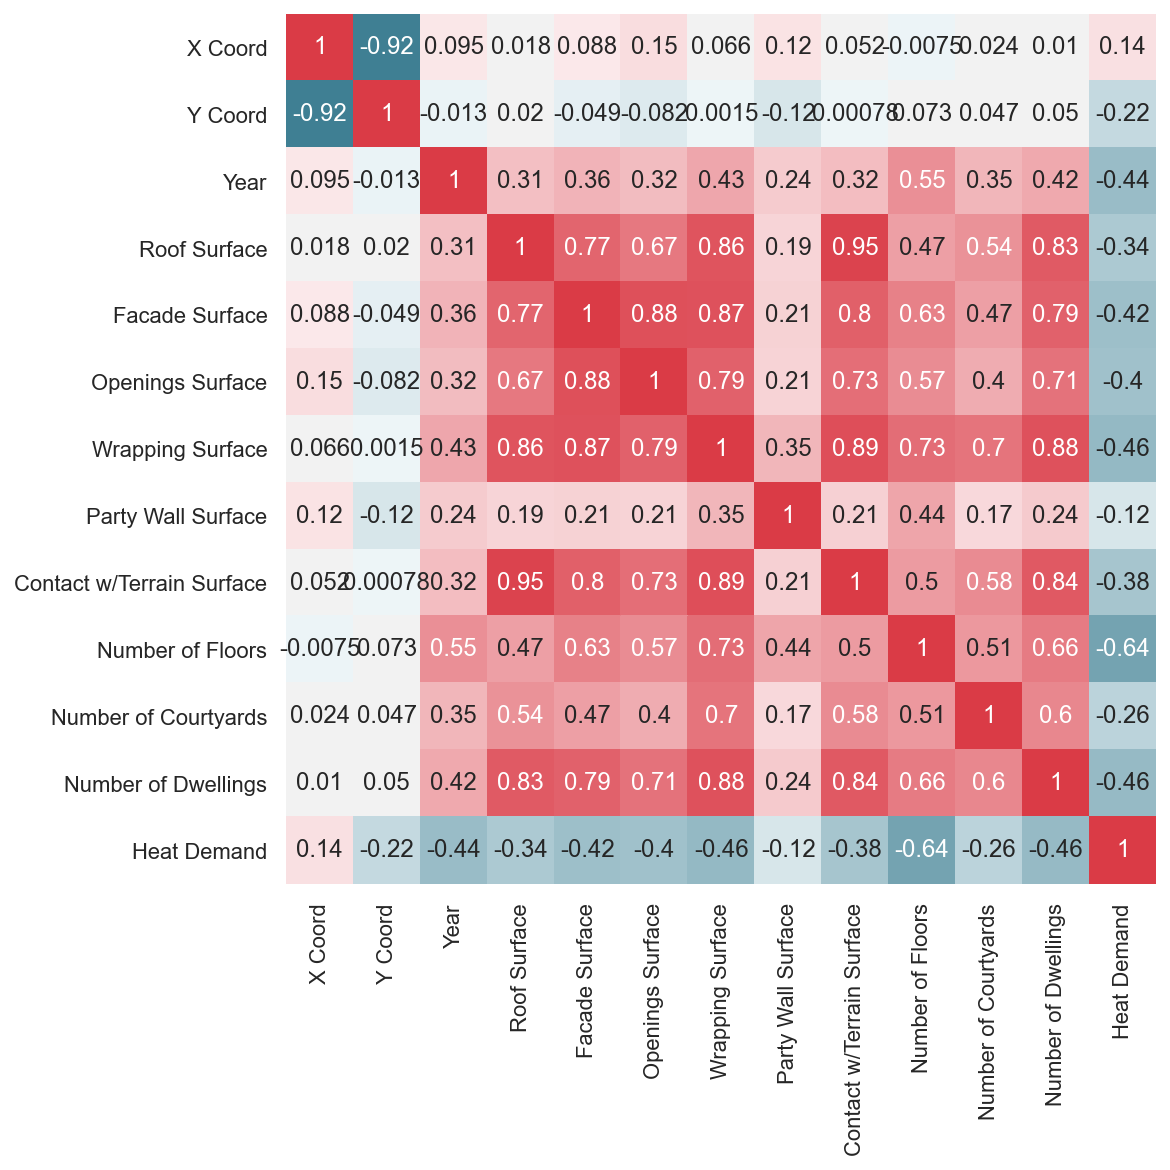

In [18]:
plt.figure(figsize = (8,8))
corr = buildings.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    corr, cmap=cmap, square=True, cbar=False, 
    annot=True, annot_kws={'fontsize':12}
)
plt.yticks(rotation=0)
plt.xticks(rotation=90) 
plt.show()

As you can see at the heat map, the correlations with the response attribute `Heat Demand` are not specially marked. However, many of the explanatory variables are strongly correlated with each other. 

See, for example, `Contact w/Terrain Surface` and `Roof Surface`. If we think about a perfectly cubic building, each of these two measurements will be the same. In reality, many buildings have varying shapes from their base to the roof, so they are not perfectly correlated. However, the linear correlation is pretty high anyway. 

This phenomenon of high correlations between predictor attributes is known as multicolinearity, and it's something that we do not want for our models. They are attributes that are considered redundant, so it is unnecessary to have both in the model. Otherwise, you'd only be adding noise to the system. 

Tree-based algorithms handle this phenomenon well, while other models might be more sensitive to it. Something we can try later is what happens if we consider all of them, or if we take the one with the highest correlation coefficient (i.e., `Wrapping Surface`).

We can get a better idea of how variables correlate with scatter plots. In the following, you can see how some patterns appear in the scatterplots (focus on the first row). 

In the diagonal, you will find the histogram corresponding to the variable on the y axis.

As there is only one instance from the year 1700, it is removed from the plots to get a better idea of the patterns.

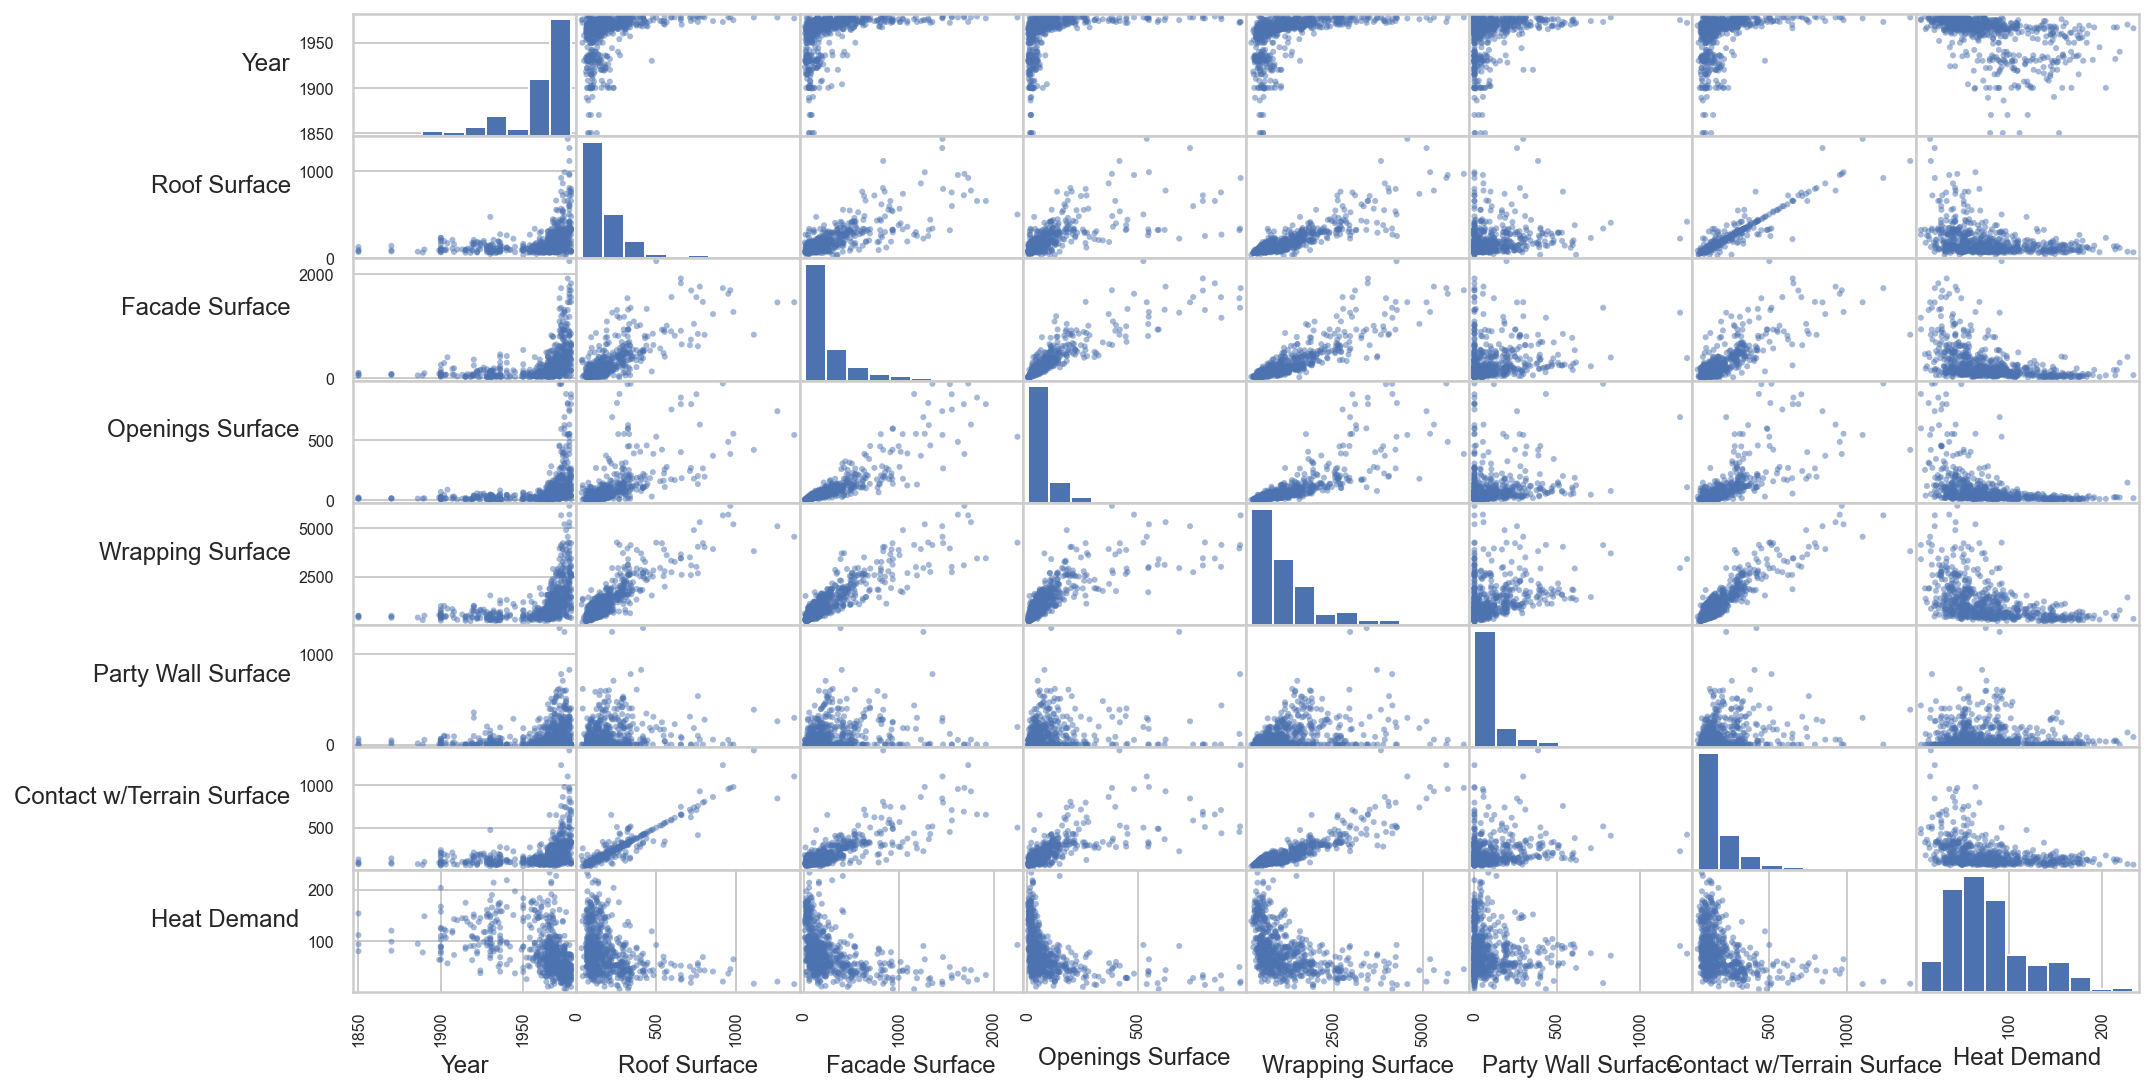

In [19]:
from pandas.plotting import scatter_matrix

exclude = ["X Coord", "Y Coord", "Number of Floors", "Number of Courtyards", "Number of Dwellings"]
sm = scatter_matrix(buildings.loc[buildings.Year > 1800, [c for c in buildings.columns if c not in exclude]], figsize=(16,9))
for subaxis in sm:
    for ax in subaxis:
        l = ax.get_ylabel()
        ax.set_ylabel(l, rotation=0, ha="right")

plt.show()

* All the surface attributes have a very similar relationship with `Heat Demand`.
* Most of the buildings were built from 1960 and on (the two last higher bars).
* There seem to be logarithmic correlations between most attributes and `Heat Demand`.

<a id='fengineering'></a>
# Attribute Combination A.K.A. Feature Engineering

Feature Engineering is the step that usually makes the difference in an ML project. Knowing the subject and its complexity can help you produce new attributes that can improve the models enormously. 

To keep it simple, I'll only try a simple logarithmic transformation on the _surface_ variables. But the best you can do is try all the combinations that you can get. We'll leave `Party Wall Surface` out, as it has many zero values and this will break our workflow.

In [20]:
surface_attrs = [col for col in buildings.columns if "Surface" in col]
surface_attrs = [a for a in surface_attrs if a != "Party Wall Surface"]

for attr in surface_attrs:
    buildings["Log "+attr] = np.log(buildings[attr].replace(0, np.nan))

And now let's compute the correlations again.

In [21]:
corr_matrix = buildings.corr()
corr_matrix["Heat Demand"].sort_values(ascending=False)

Heat Demand                      1.000000
X Coord                          0.138257
Party Wall Surface              -0.116543
Y Coord                         -0.217586
Number of Courtyards            -0.264093
Roof Surface                    -0.341468
Log Roof Surface                -0.364450
Contact w/Terrain Surface       -0.375108
Openings Surface                -0.403764
Log Contact w/Terrain Surface   -0.414675
Facade Surface                  -0.420780
Year                            -0.439196
Number of Dwellings             -0.458880
Wrapping Surface                -0.464788
Log Facade Surface              -0.543432
Log Wrapping Surface            -0.555474
Log Openings Surface            -0.587757
Number of Floors                -0.635959
Name: Heat Demand, dtype: float64

Not surprisingly, all the transformed attributes got a stronger (negative) linear correlation with `Heat Demand`. Here is how these transformed variables look like when plotted against our target variable.

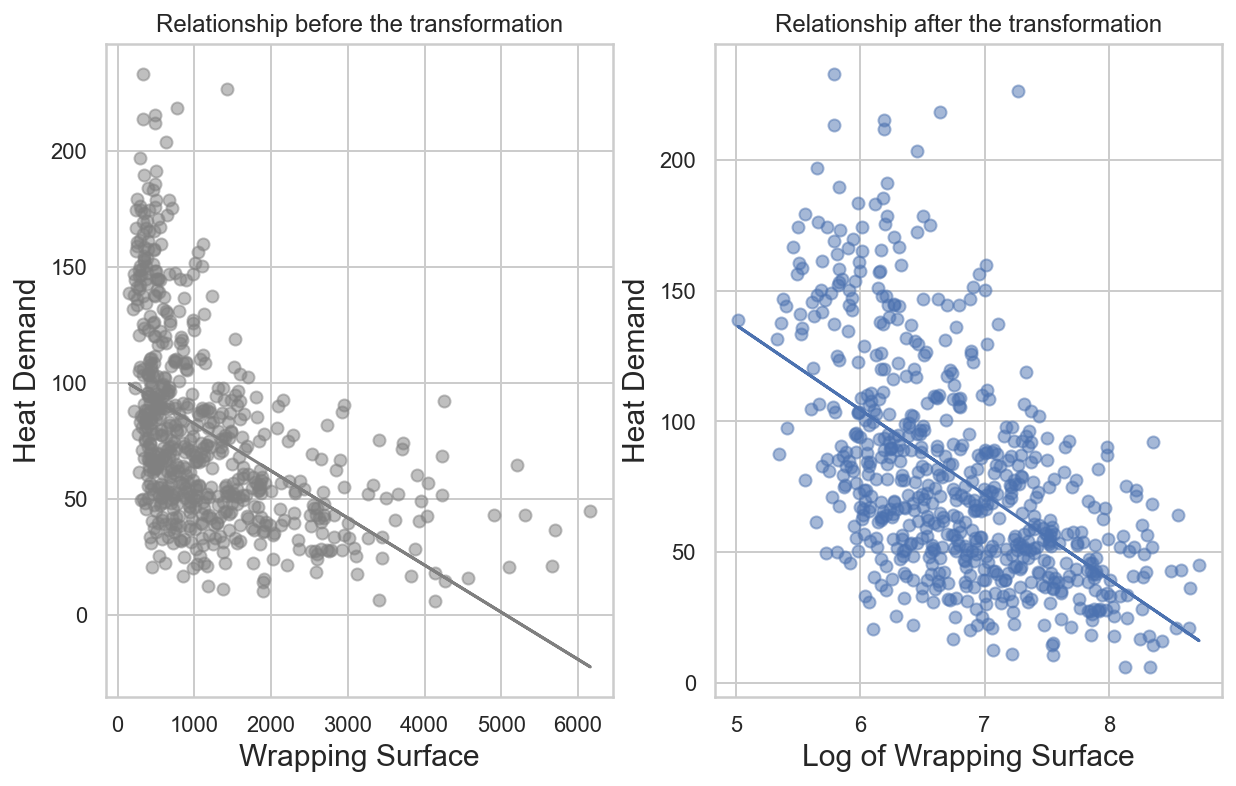

In [22]:
x1 = np.array(buildings["Wrapping Surface"])
x2 = np.array(buildings["Log Wrapping Surface"])
y = np.array(buildings["Heat Demand"])

m1, b1 = np.polyfit(x1, y, 1)
m2, b2 = np.polyfit(x2, y, 1)

fig, ax = plt.subplots(1,2)

ax[0].scatter(x1, y, alpha = .5, c="grey")
ax[0].plot(x1, m1*x1 + b1, c="grey")

ax[0].set_xlabel("Wrapping Surface", fontsize=15)
ax[0].set_ylabel("Heat Demand", fontsize=15)
ax[0].set_title("Relationship before the transformation")

ax[1].scatter(x2, y, alpha = .5)
ax[1].plot(x2, m2*x2 + b2)

ax[1].set_xlabel("Log of Wrapping Surface", fontsize=15)
ax[1].set_ylabel("Heat Demand", fontsize=15)
ax[1].set_title("Relationship after the transformation")

plt.show()

Definitely better!

# Prepare Data for ML ALgorithms

The **first thing is to revert to a clean training set and separate predictors from labels**, as we don't necessarily want to apply the same transformations to each one of them. 

We'll work with a copy of `buildings_train_set`, overwriting `buildings` as we did earlier (notice that `drop()` will create a copy of the data and it does not affect `buildings_train_set`).

In [23]:
buildings = buildings_train_set.drop("Heat Demand", axis=1)
buildings_labels = buildings_train_set["Heat Demand"].copy()

## Outliers

Data preparation must include outlier removal. Outliers, or in other words, data noise, produce less consistent models. Let's plot the distribution of the target variable to see if we can easily detect outliers.

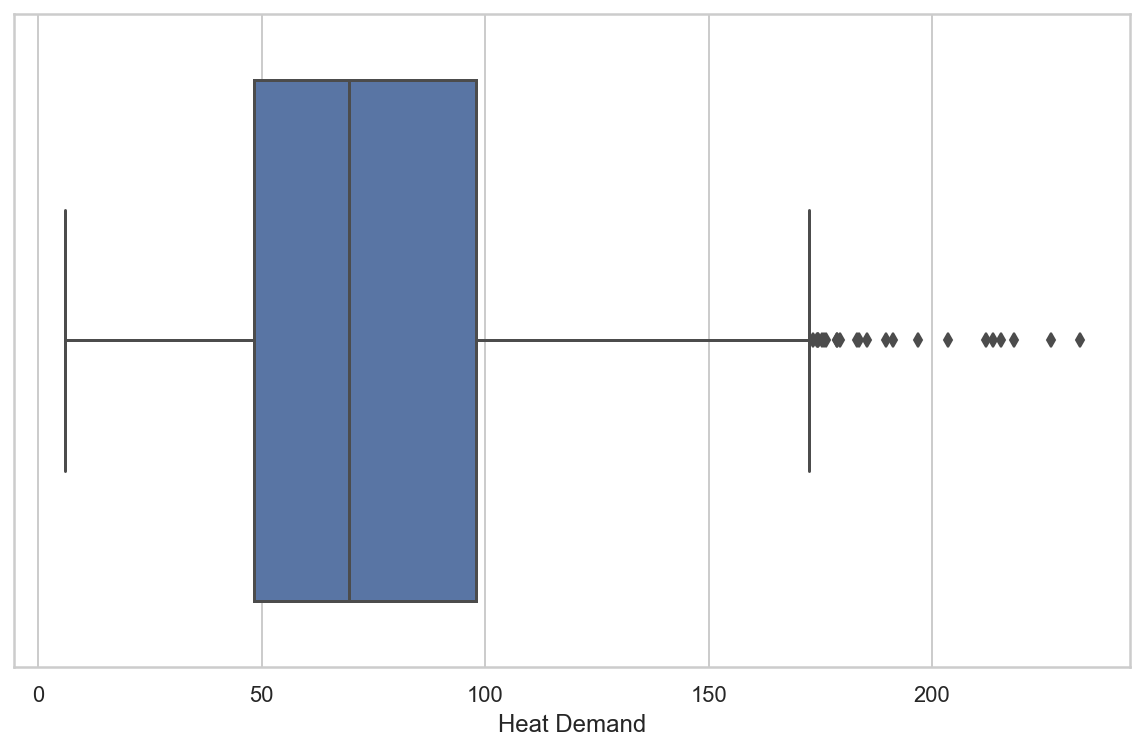

In [24]:
sns.boxplot(x=buildings_labels)
plt.show()

As we can see above, there are a few points over the 75% quantile of the distribution (to the right of the boxplot's rightest whisker). It is hard to determine if all of them should be considered outliers.

It seems that there isn't a clear boundary between the points that are outliers and those that aren't. So, instead of using the IQR method (i.e., delete outliers based on the boxplot), let's use the `z-score` method. It is suitable as `Heat Demand` shows a distribution similar to the normal.

In [25]:
from scipy import stats
import numpy as np

def drop_outliers_by_zscore(s, threshold=3):  
    z_score = np.abs(stats.zscore(s))
    idx = np.where(z_score < threshold)
    return s.iloc[idx[0],]

In [26]:
buildings_labels_z = drop_outliers_by_zscore(buildings_labels, threshold=3)
sentence = "Instances deleted: "
pctg = 100*(buildings_labels.shape[0] - buildings_labels_z.shape[0]) / (buildings_labels.shape[0])
print(sentence, "{:.2f}% of the data".format(pctg))

Instances deleted:  0.92% of the data


Finally, we can overwrite the `buildings` variable without the outliers.

In [27]:
buildings = buildings.loc[buildings_labels_z.index]
buildings_labels = buildings_labels.loc[buildings_labels_z.index]

## Categorical Attributes

The following are the categorical attributes in the dataset.

In [28]:
buildings_cat = buildings.select_dtypes(("object", "category"))
buildings_cat_names = buildings_cat.columns.values.tolist()
buildings_cat_names

['District',
 'Main Orientation',
 'GF Usage',
 'Type of Roof',
 'Type of Opening',
 'Type of Party Wall',
 'Type of Facade']

Machine Learning Models require numerical data to be able to work. Then, we should treat categorical data before feeding ML models with them.

As we won't consider an order relationship between categories, we will replace the categorical attributes with _dummy variables_. This is, replacing the categorical attribute with a new column for each category in it and then assigning a 1 for the column corresponding to the instance's category and a 0 for the rest.

In [29]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
buildings_cat_1hot = cat_encoder.fit_transform(buildings_cat)

Now, each column in the array corresponds to a category in the original attribute.

## Custom Transformers

Custom Transformers will allow us to produce more complex data preparation steps than the standard ones provided by Scikit-Learn. 

We need to create a custom class to transform our _surface_ variables to their logarithm.

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

roof_idx, facade_idx, openings_idx = 3, 4, 5
wrapping_idx, party_idx, terrain_idx = 6, 7, 8

class LogTransformAttrs(BaseEstimator, TransformerMixin):
    def __init__(self, log_transform_attrs=True):
        self.log_transform_attrs = log_transform_attrs
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if not self.log_transform_attrs:
            return X
        else:
            log_roof = np.nan_to_num(np.log(X[:,roof_idx]))
            log_facade = np.nan_to_num(np.log(X[:, facade_idx]))
            log_openings = np.nan_to_num(np.log(X[:, openings_idx]))
            log_wrapping = np.nan_to_num(np.log(X[:, wrapping_idx]))
            log_terrain = np.nan_to_num(np.log(X[:, terrain_idx]))
            return np.c_[X, log_roof, log_facade, log_openings, log_wrapping, log_terrain]

And let's add another custom transformer to drop the multicollinear attributes.

In [31]:
buildings_num = buildings.select_dtypes(("float64", "int64"))

list(zip(range(len(buildings_num)), buildings_num.columns.values))

[(0, 'X Coord'),
 (1, 'Y Coord'),
 (2, 'Year'),
 (3, 'Roof Surface'),
 (4, 'Facade Surface'),
 (5, 'Openings Surface'),
 (6, 'Wrapping Surface'),
 (7, 'Party Wall Surface'),
 (8, 'Contact w/Terrain Surface'),
 (9, 'Number of Floors'),
 (10, 'Number of Courtyards'),
 (11, 'Number of Dwellings')]

In [32]:
multicollinear_attrs_idx = [range(3,8), range(12,17)]

class KeepMulticollinearAttrs(BaseEstimator, TransformerMixin):
    def __init__(self, keep_multicollinear_attrs=True):
        self.keep_multicollinear_attrs = keep_multicollinear_attrs
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if not self.keep_multicollinear_attrs:
            return X
        else:
            X = np.array(X)
            return np.delete(X, multicollinear_attrs_idx, axis=1)

## Feature Scaling

The year a building was built has a very different scale than the number of floors it can have. This can degrade the predictive performance of many machine learning algorithms.

To tackle this, we can use scaling techniques. Here, we will try several methods to go beyond the default class used in many Machine Learning Projects `StandardScaler()`. Scikit-Learn provides several classes (not all are included here) to do so.

We will test no scaling too.

In [33]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

class CustomScaler(BaseEstimator, TransformerMixin):
    """
    Choose one of the following values for the scaler parameter:
    -  None: Data wont be scaled
    - 'standard': StandardScaler()
    - 'minmax': MinMaxScaler()
    - 'maxabs': MaxAbsScaler()
    - 'robust': RobustScaler()
    """
    def __init__(self, scaler='standard'):
        valid_scalers = [None, 'standard', 'minmax', 'maxabs', 'robust']
        self.scaler = scaler
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.scaler is None:
            return np.array(X)
        elif self.scaler == 'standard':
            return StandardScaler().fit_transform(X)
        elif self.scaler == 'minmax':
            return MinMaxScaler().fit_transform(X)
        elif self.scaler == 'maxabs':
            return MaxAbsScaler().fit_transform(X)
        elif self.scaler == 'robust':
            return RobustScaler().fit_transform(X)
        else:
            raise ValueError("Invalid Scaler: '{}'; choose one of:\n {}".format(self.scaler, valid_scalers))

For more information on how these classes work, [visit this page](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html).

## Transformation Pipelines

To have better control over the transformation process, we implement _Pipelines. It prevents us from doing each step manually. With pipelines, every stage of the transformation process is produced automatically in the stipulated order. The output of the preceding stage will be the input of the following one.

This, together with the custom transformers, will make these transformations optional and combinable in an automated manner. Thus we can test which mix of hyperparameters gives us the best model performance.

There are some missing values in the coordinates. Most algorithms are not able to deal with missing values. 

Here, we will try the Scikit-Learn's `KNNImputer`. This imputer will take the mean of its `k` nearest neighbors. The nearest neighbors are selected through the euclidean distance between individuals, taking into account all attributes. This will emulate the geographical distribution of buildings with similar characteristics to those whose coordinates are missing.

We will include all these transformations in a pipeline to deal with the numerical attributes.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

num_pipeline = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors=3, weights="uniform")),
    ('log_transform_attrs', LogTransformAttrs(log_transform_attrs=True)),
    ('keep_multicollinear_attrs', KeepMulticollinearAttrs(keep_multicollinear_attrs=True)),
    ('custom_scaler', CustomScaler(scaler='standard'))
])

Next, we should include a pipeline to transform categorical attributes.

With the categorical pipeline we will impute _one-hot encoding_ over all the categorical variables.

In [35]:
cat_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder())
])

Finally, we use the `ColumnTransformer()` class to implement all transformations (over numerical and categorical data) in the same pipeline.

In [36]:
from sklearn.compose import ColumnTransformer

buildings_num = buildings.select_dtypes(("float64", "int64"))

num_attribs = list(buildings_num.columns.values)
cat_attribs = list(buildings_cat.columns.values)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

buildings_prepared = full_pipeline.fit_transform(buildings)

# Model Selection and Training

All the hardest work is already done. We have gone through data exploration, the visual analysis, and the data preparation steps. Those usually are the most time consuming ones. The following steps are where the fun part is. Let's dive in the Machine Learning Models!

This step consists in trying out several models (for a regression task, in this case) to see which performs best. Let’s start simple by training a Linear Regression Model first.

In [37]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(buildings_prepared, buildings_labels)

LinearRegression()

Let's print some target values and some predictions to see how it is working.

In [38]:
some_data = buildings.iloc[:5]
some_labels = buildings_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [103.76987399 116.87305424  61.23122586  73.07063043  43.91294883]


In [39]:
print("Labels:", list(some_labels))

Labels: [83.80830072, 88.95706649, 53.80141858, 88.2675733, 12.44289642]


It works, although the predictions are not exactly accurate. Let's measure this Regression Model's RMSE on the whole training set. We are using Scikit-Learn's `mean_squared_error()` function to do this.

In [40]:
from sklearn.metrics import mean_squared_error

buildings_predictions = lin_reg.predict(buildings_prepared)
lin_mse = mean_squared_error(buildings_labels, buildings_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

25.345506965801086

This is not a bad score at all. Heat Demand median values are between X and Y kWh, so a typical prediction error of 23.6 kWh is not a big deal.

Let's try other models anyway. We can experiment now with a Decision Tree.

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(buildings_prepared, buildings_labels)

DecisionTreeRegressor()

In [42]:
buildings_predictions = tree_reg.predict(buildings_prepared)
tree_mse = mean_squared_error(buildings_labels, buildings_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

It could seems like we have found the perfect model, but slow down! It is more likely that the model is overfitting than it is perfect. 

At this point, it is important to **remember that we don't want to touch the test set until we are ready to launch a model that we are confident about**, so before doing this, we will use a part of the training set and part of it for validation in the operation known as _cross-validation_.

## Better Evaluation Using Cross-Validation

To put it in few words, _cross-validation_ is an iterative process which consists in training the model in different subsets of the (training) data, to then get the final predictions by averaging the results of each step in the iteration. It is used to ensure that the results are independent of the partition of the data.

The fastest way to implement cross-evaluation is using the Scikit-Learn's _K-fold cross validation_ feature. The following code randomly splits the training set into 10 distinct subsets called _folds,_ then trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [43]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, buildings_prepared, buildings_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

This process will output a series of 10 scores, one for each cross validation set. We can average errors to get the overall score.

In [44]:
def display_result(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std Deviation: ", scores.std())
    
display_result(tree_rmse_scores)

Scores:  [26.54954224 27.79235854 32.44345977 33.57702534 36.17330474 33.09683029
 33.41218125 27.06757322 31.67633833 32.06865116]
Mean:  31.38572648894211
Std Deviation:  3.022815762044624


A `RandomForestRegressor`, is an esamble method. It takes several trees and averages the results of their predictions.

In [45]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(buildings_prepared, buildings_labels)

RandomForestRegressor(random_state=42)

In [46]:
%%time
scores = cross_val_score(forest_reg, buildings_prepared, buildings_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

CPU times: user 4.17 s, sys: 74.4 ms, total: 4.24 s
Wall time: 4.33 s


Notice that we used the `neg_mean_squared_error_` scoring. It is because the Scikit-Learn's cross-validation feature expects a utility function (greater is better) rather than a cost function (lower is better), so the scoring is actually the opposite of the MSE (conceptually, a negative value), which is why we computed the `-scores` before calculating the root.

In [47]:
buildings_predictions = forest_reg.predict(buildings_prepared)
forest_mse = mean_squared_error(buildings_labels, buildings_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

8.644814510603776

In [48]:
display_result(forest_rmse_scores)

Scores:  [20.21687    24.67765147 26.139569   21.65923016 27.14990823 23.81610299
 25.60419604 20.54039775 24.45641516 25.65652972]
Mean:  23.991687050524966
Std Deviation:  2.286438063457149


Random Forests seems to work better than Linear Regression! However, notice that **the score on the train set is quite lower than in the validation sets**. This is due to **overfitting** in the training set. The possible solutions to this common Machine Learning problem are:

* Geting more data
* Feeding the model with new and more significat attributes
* Regularizing the model, i.e., use hyperparameters to apply constrains over it.

**We have to try several other models before we dive deeper into Random Forest and fine-tuning**. E.g., we should try out Support Vector Machines with different kernels, and possibly a neural network, without spending too much time tweaking the hyperparameters. **The goal is to shortlist a few (two to five) promising models**.

Let's, then, try the Scikit-Learn's Super Vector Machine Regressor (`SVR`).

In [49]:
from sklearn.svm import SVR

svm_reg_linear = SVR(kernel='linear')
svm_reg_linear.fit(buildings_prepared, buildings_labels)
svm_linear_scores = cross_val_score(svm_reg_linear, buildings_prepared, buildings_labels,
                             scoring="neg_mean_squared_error", cv=10)
svm_linear_rmse_scores = np.sqrt(-scores)

In [50]:
svm_linear_rmse_scores.mean()

23.991687050524966

In [51]:
buildings_predictions = svm_reg_linear.predict(buildings_prepared)
svm_linear_mse = mean_squared_error(buildings_labels, buildings_predictions)
svm_linear_rmse = np.sqrt(svm_linear_mse)
svm_linear_rmse

26.268653744333175

And now with a `rbf` kernel.

In [52]:
svm_reg_rbf = SVR(kernel='rbf')
svm_reg_rbf.fit(buildings_prepared, buildings_labels)
svm_rbf_scores = cross_val_score(svm_reg_rbf, buildings_prepared, buildings_labels,
                             scoring="neg_mean_squared_error", cv=10)
svm_rbf_rmse_scores = np.sqrt(-scores)

In [53]:
svm_rbf_rmse_scores.mean()

23.991687050524966

In [54]:
buildings_predictions = svm_reg_rbf.predict(buildings_prepared)
svm_rbf_mse = mean_squared_error(buildings_labels, buildings_predictions)
svm_rbf_rmse = np.sqrt(svm_rbf_mse)
svm_rbf_rmse

31.901848358497052

As we can see, the `SVR`'s RMSE is a little bit worse than the `RandomForestRegressor`'s one.

Since there is not much difference in the point estimates of the generalization error between the models we tried out, we may not be sure to decide for one of them.

To have an idea of how precise our models are, we can set a 95% _confidence interval_ for the generalization error using `scipy.stats.t.interval()`. 

This statistical technique also fits like a glove in the scenario where you are trying a model different from the current production one and you don't know if such a point estimate of the generalization error after testing &mdash;in the test set&mdash; your new model is quite enough to convince you to launch it.

In [55]:
predictions = {
    "lin_reg": lin_reg.predict(buildings_prepared),
    "forest_reg": forest_reg.predict(buildings_prepared),
    "svm_linear": svm_reg_linear.predict(buildings_prepared),
    "svm_rbf": svm_reg_rbf.predict(buildings_prepared)
}

In [56]:
from scipy import stats

confidence = .95

for key in predictions.keys():
    print(key)
    squared_errors = []
    for i in range(len(buildings_labels)):
        squared_errors.append((predictions[key][i] - buildings_labels.iloc[i]) ** 2)
    if key == "forest_reg": 
        intervals = [forest_rmse_scores.mean()-forest_rmse_scores.std(), forest_rmse_scores.mean()+forest_rmse_scores.std()]
    else:
        squared_errors = np.array(squared_errors)
        intervals = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, # minus one degree of freedom
                                                loc=np.mean(squared_errors),
                                                scale=stats.sem(squared_errors)))
    print(intervals)

lin_reg
[23.72919552 26.86474878]
forest_reg
[21.70524898706782, 26.278125113982114]
svm_linear
[24.3688954  28.03999423]
svm_rbf
[29.61498898 34.03539753]


At this point we could choose almost any model that we have tried, as the obtained scores are not really that different. In this type of scenario we should opt for explainability (it's better to know what models are doing!). 

From the models tried, Linear Regression and Random Forest are the most explainable ones. It is not important here to know why, but to get the concept.

Based on this premise and the fact that **Random Forest** obtained a slightly better score than Linear Regression, we will choose the first one as the definitive model for our data.

## Fine-Tunning

Now that we know that we have selected our model, it is time to try out several parameters to make the best of it. One of the main approaches to do that is using Scikit-Learn's `GridSearch()`. We provide a series of parameters and the algorithm will try all the possible combinations to search for the one which leads to the best result.

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[30, 100, 130, 200, 230], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [30, 230, 1530], 'max_features':[4, 6, 8, 12]}
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                              scoring='neg_mean_squared_error',
                              return_train_score=True)

In [58]:
%%time
grid_search.fit(buildings_prepared, buildings_labels)

CPU times: user 1min 52s, sys: 3.41 s, total: 1min 56s
Wall time: 2min 4s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [30, 100, 130, 200, 230]},
                         {'bootstrap': [False], 'max_features': [4, 6, 8, 12],
                          'n_estimators': [30, 230, 1530]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [59]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 100}

In [60]:
curves = grid_search.cv_results_
for mean_score, params in zip(curves["mean_test_score"], curves["params"]):
    print(np.sqrt(-mean_score), params)

26.6044004632462 {'max_features': 2, 'n_estimators': 30}
26.035001136857485 {'max_features': 2, 'n_estimators': 100}
25.920814360479277 {'max_features': 2, 'n_estimators': 130}
25.89919561632609 {'max_features': 2, 'n_estimators': 200}
25.912073613870824 {'max_features': 2, 'n_estimators': 230}
25.453125449702135 {'max_features': 4, 'n_estimators': 30}
25.106635408589856 {'max_features': 4, 'n_estimators': 100}
25.1346732871655 {'max_features': 4, 'n_estimators': 130}
25.018033036465585 {'max_features': 4, 'n_estimators': 200}
24.9765590883556 {'max_features': 4, 'n_estimators': 230}
24.69980451778215 {'max_features': 6, 'n_estimators': 30}
24.67429001524983 {'max_features': 6, 'n_estimators': 100}
24.60994213493808 {'max_features': 6, 'n_estimators': 130}
24.6612358309989 {'max_features': 6, 'n_estimators': 200}
24.597925890794535 {'max_features': 6, 'n_estimators': 230}
24.57695549269803 {'max_features': 8, 'n_estimators': 30}
24.194391904618378 {'max_features': 8, 'n_estimators': 10

The main problem with this approach is that we generally do not know which ranges of parameters are the optimal. The best value for the `n_estimators` parameter was the highest value of the ones passed. That might indicate that the best value for this parameter is actually above the one we provide, and that we should expand the range we gave in the `GridSearchCV` distribution and try again.

So, instead of doing this, we can prove another approach to look for the best parameters for a model, which is the Scikit-Learn's `RandomizedSearchCV()` class. The latter usually means achieving better results in the same amount of time.

In this case, we can stipulate any random distribution to search for each parameter. As our parameters are integers, we will use the `scipy.stats.randint()` function, that generates a discrete uniform distribution in which any value in the range provided is equally likely to happen. 

In [61]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distrib = {
    'bootstrap': [True, False],
    'n_estimators':randint(1,1000),
    'max_features': randint(4,45)
}

forest_reg = RandomForestRegressor()
random_search = RandomizedSearchCV(forest_reg, param_distrib, n_iter=50, 
                                   cv=5, n_jobs=2, random_state=42,
                                   scoring='neg_mean_squared_error')
random_search.fit(buildings_prepared, buildings_labels)

CPU times: user 1.99 s, sys: 151 ms, total: 2.14 s
Wall time: 2min 34s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50, n_jobs=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fea7c0817f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fea7c081b20>},
                   random_state=42, scoring='neg_mean_squared_error')

In [62]:
negative_mse = random_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

23.857078439373176

And indeed the `RandomizedSearchCV()` improved by 0.5 points of error estimate expending the same amount of time than `GridSearchCV()`! The best parameters for the model were the following.

In [63]:
random_search.best_params_

{'bootstrap': True, 'max_features': 18, 'n_estimators': 456}

Now it is time to implement a single pipeline with preparation and prediction. 

In [64]:
from sklearn.model_selection import RandomizedSearchCV

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('forest_prediction', RandomForestRegressor(**random_search.best_params_))
])

prepare_select_and_predict_pipeline.fit(buildings, buildings_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('log_transform_attrs',
                                                                   LogTransformAttrs()),
                                                                  ('keep_multicollinear_attrs',
                                                                   KeepMulticollinearAttrs()),
                                                                  ('custom_scaler',
                                                                   CustomScaler())]),
                                                  ['X Coord', 'Y Coord', 'Year',
                                                   'Roof Surface',
                                              

Let's see how does the predictions look like!

In [65]:
some_data = buildings[:4]
some_labels = buildings_labels[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [105.03603606 110.61694487  51.50016845  81.15394564]
Labels:		 [83.80830072, 88.95706649, 53.80141858, 88.2675733]


Now we can try out several hyperparameters that have not been explored yet, that is, those related to the preparation process.

In [66]:
# uncomment to see pipeline avilable parameters
# prepare_select_and_predict_pipeline.get_params().keys()

In [67]:
param_grid = [{
    'preparation__num__knn_imputer__n_neighbors': range(1,5),
    'preparation__num__keep_multicollinear_attrs__keep_multicollinear_attrs': [False, True],
    'preparation__num__custom_scaler__scaler': [None, 'standard', 'minmax', 'maxabs', 'robust']
}]

In [68]:
grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid=param_grid, 
                                cv=5, scoring='neg_mean_squared_error')

grid_search_prep.fit(buildings, buildings_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('knn_imputer',
                                                                                          KNNImputer(n_neighbors=3)),
                                                                                         ('log_transform_attrs',
                                                                                          LogTransformAttrs()),
                                                                                         ('keep_multicollinear_attrs',
                                                                                          KeepMulticollinearAttrs()),
                                                                                         ('custom_scaler',
                                                      

### Saving models

Training a model or fine-tuning it could be a very time consuming process. Instead of doing it over and over, we can save our results with the `joblib` library.

In [69]:
import joblib

joblib.dump(grid_search_prep, "models/grid_search_prep.pkl")

['models/grid_search_prep.pkl']

And then, we can load it again with the following code:

In [70]:
grid_search_prep = joblib.load("models/grid_search_prep.pkl")

In [71]:
grid_search_prep.best_params_

{'preparation__num__custom_scaler__scaler': None,
 'preparation__num__keep_multicollinear_attrs__keep_multicollinear_attrs': False,
 'preparation__num__knn_imputer__n_neighbors': 3}

Now we know that we need neither to combine attributes nor discretizing any of them. 

Though it might seem otherwise, it is not so surprising that not scaling the data is the best option to get the best of our model. The physical model used to obtain the estimate energy consumption of buildings used the attributes as they are. This behavior is not usual with models built with the right data.

## Analyzing Errors

A good way to gain insight of what is happening is by inspecting the best models. To do that, we can start by looking at the relative importances of each feature in the Random Forest model.

In [72]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.06066853, 0.0746299 , 0.09964956, 0.0776802 , 0.15653263,
       0.0199092 , 0.12629088, 0.00690206, 0.006457  , 0.00566188,
       0.00588034, 0.00481823, 0.01717131, 0.00807724, 0.00549096,
       0.00421344, 0.0051471 , 0.01064653, 0.0183943 , 0.00392053,
       0.00122938, 0.01122458, 0.13826697, 0.01993903, 0.0073516 ,
       0.00185091, 0.00341028, 0.00925822, 0.00777062, 0.00098516,
       0.01389711, 0.0087543 , 0.00670827, 0.00159479, 0.01686689,
       0.00551492, 0.02723516])

To get a better understanding, let's plot the feature importances along with its corresponding attribute.

In [73]:
extra_attribs = ["wrp_sfc_per_floor"]
cat_encoder = full_pipeline.named_transformers_["cat"]["one_hot_encoder"]
cat_one_hot_attribs = cat_encoder.get_feature_names(cat_attribs)
attributes = num_attribs + list(cat_one_hot_attribs) + extra_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.15653263053738883, 'Facade Surface'),
 (0.13826697235862817, 'GF Usage_Commercial'),
 (0.12629087831183605, 'Wrapping Surface'),
 (0.0996495577592796, 'Year'),
 (0.07768019871009466, 'Roof Surface'),
 (0.07462989795555479, 'Y Coord'),
 (0.06066853076961617, 'X Coord'),
 (0.027235157571822804, 'Type of Party Wall_M1'),
 (0.019939033212023186, 'GF Usage_Dwelling'),
 (0.01990919681879284, 'Openings Surface'),
 (0.018394301324823524, 'Main Orientation_S'),
 (0.017171311328637612, 'District_Marianao'),
 (0.01686688596298618, 'Type of Opening_H5'),
 (0.013897114121189498, 'Type of Opening_H1'),
 (0.011224582209856695, 'Main Orientation_W'),
 (0.010646529031484345, 'Main Orientation_NW'),
 (0.009258221968397075, 'Type of Roof_C2'),
 (0.008754304013965987, 'Type of Opening_H2'),
 (0.00807724263560219, 'District_Vinyets'),
 (0.007770619928659448, 'Type of Roof_C3'),
 (0.007351598544812038, 'GF Usage_Industrial'),
 (0.006902058119226561, 'Party Wall Surface'),
 (0.006708271376605037, 'Type o

With this information, the next step would be proceeding to clean up our data and model. 

For example, we see how some of the extra attributes added in the data transformation process have a relatively high importance value. However, from the grid search we know that it will work better without them. Then, we could drop them.

Yet, we'll continue with the overall workflow of the Machine Learning Project and go directly to the Model Testing  step.

## Model Testing

Before testing our model, we must add the extra attributes to the Test Set to make the pipeline work.

In [74]:
X_test = buildings_test_set.drop("Heat Demand", axis=1)
y_test = buildings_test_set["Heat Demand"].copy()
X_test_num = X_test.select_dtypes(("float64", "int64"))

X_test_extra_attrs = create_discretized_attrs(X_test_num)

NameError: name 'create_discretized_attrs' is not defined

Then, combine all together.

In [ ]:
X_test = pd.concat([X_test, X_test_extra_attrs], axis=1)

And finally make the predictions and getting the error!

In [ ]:
final_model = grid_search.best_estimator_

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

Error is similar in the training and test set and it is even lower in the latter. That means that our model is generalizing well what it is learning.

**[REVIEW: References]**
**[REVIEW: No REVIEWS left]**

# Take aways

The main ideas to take away from this study are the following:
* In this project some of the most common problems of Machine Learning were faced:
    * Insufficient quantity of data: to design a solid building renovation strategy it would be appropriate to have more instances or cases and more information about each of them (social and demographic variables, others related to climate, etc.).
    * Poor-quality data. Validated and consolidated data are essential to build powerful models.
* In the present context, this should be tackled through making energy cosumption data accesible. This would favour governance and sustainablity.
* Machine Learning has a high potential when it comes to spending energy more wisely. **However, it is essential to accompany the increase in efficiency in a conscious reduction of consumption, especially in those that have greater availability due to their economic situation**.

While doing this excercise other ideas for Machine Learning applications regariding building stock and energy cosumption arose:

* A model to classify buildings regarding their potential to be susceptible of an renovation. This would have to be done taking into account all kind of variables to avoid producing models which impair some individuals in favour of others.
* A model to detect errors in building data collection. This way the procedure of data collection for institutions like the Cadastre could become less resource intensive.

<a id='references'></a>
# References

\[1\] [^](#top) AAVV, Master en Intervención Sostenible en el Medio Construído (2018). "Repensar lo edificado. Propuesta de Intervención Sostenible para los barrios de Marianao y Vinyets, Sant Boi de Llobregat". https://issuu.com/sergioleonardopinzon/docs/dossier_re-pensar_lo_edificado_mism.

\[2\] [^](#context) Quick, Kimberly (2015)."The Unfair Effects of IMPACT on Teachers with the Toughest Jobs". The Century Foundation. Accesed June 2020 from: https://tcf.org/content/commentary/the-unfair-effects-of-impact-on-teachers-with-the-toughest-jobs/?agreed=1

\[3\] [^](#jeavons) Bauer, Diana; Papp, Kathryn (2009). "Book Review Perspectives: The Jevons Paradox and the Myth of Resource Efficiency Improvements". Sustainability: Science, Practice, & Policy. 5 (1). doi:10.1080/15487733.2009.11908028.

\[4\] [^](#measure) Géron, Aurélien (2019). "Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow". O'Reilly. pg. 39.

\[5\] [^](#fengineering) Kuhn, M and Johnson, Kjell. 2019. “Feature Engineering and Selection: A Practical Approach for Predictive Models”. http://www.feat.engineering/numeric-one-to-many.html#binning